In [1]:
# import data
from BidataGen import sample_p
from model import LBFIS, gaussian_mix
from BidataGen import cav_HF as HF
from BidataGen import cav_LF as LF
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
num_variable = 52
sample = lambda n: sample_p(n, num_variable)
def h_LF(x):
    if (x < -1).any() or (x > 1).any():
        return torch.tensor(100.0)
    return -0.2320 - LF(x)
def h_HF(x):
    if (x < -1).any() or (x > 1).any():
        return torch.tensor(100.0)
    return -0.2320 - HF(x)
# h_LF = lambda x: -0.2320 - LF(x)
# h_HF = lambda x: -0.2320 - HF(x)
ExH = np.mean((h_HF(sample(int(1e6))) < 0).detach().numpy())

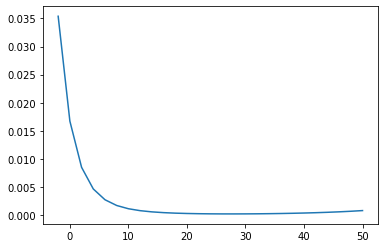

In [25]:
# selcting optimal ell
L = int(1e3)
M = int(1e6)
# fix samples
samps_M = sample(M)
samps_L = sample(L)
h_samps_M = h_LF(samps_M)
h_samps_L = h_HF(samps_L)
h_samps_LL = h_LF(samps_L)
def Zl(ell):
    return (-ell*torch.tanh(h_samps_M)).exp().sum() / M
def V(ell):
    varq1 = (torch.exp(ell*torch.tanh(h_samps_LL))[h_samps_L < 0]).sum() / L
    varq2 = ((h_samps_L < 0).sum())**2 / (L**2)
    return Zl(ell) * varq1 - varq2

ell_lst = np.linspace(-2, 50, 27)
V_lst = [V(torch.tensor(ell)).item() for ell in ell_lst]

plt.plot(ell_lst, V_lst)
if torch.sum(h_samps_L < 0) > 0:
    ell = ell_lst[torch.argmin(torch.tensor(V_lst))]
else:
    ell = 1.0
est = LBFIS(h_LF, sample, ell, num_variable)

In [27]:
ell

28.0

In [28]:
# from tqdm import tqdm
# def log_Q(potential, z_prime, z, step):
#     z.requires_grad_()
#     grad = torch.autograd.grad(potential(z).mean(), z)[0]
#     return -(torch.norm(z_prime - z + step * grad, p=2, dim=1) ** 2) / (4 * step)

# def metropolis_adjusted_langevin_algorithm(potential, n_samples=int(1e4), step=1e-2):
#     burn_in = int(1e3)
#     Z0 = sample(1)
#     Zi = Z0
#     samples = []
#     pbar = tqdm(range(n_samples + burn_in))
#     for i in pbar:
#         Zi.requires_grad_()
#         u = potential(Zi).mean()
#         grad = torch.autograd.grad(u, Zi)[0]
#         prop_Zi = Zi.detach() - step * grad + np.sqrt(2 * step) * torch.randn(1, num_variable)
#         log_ratio = -potential(prop_Zi).mean() + potential(Zi).mean() +\
#                     log_Q(potential, Zi, prop_Zi, step) - log_Q(potential, prop_Zi, Zi, step)
#         if torch.rand(1) < torch.exp(log_ratio):
#             Zi = prop_Zi
#         samples.append(Zi.detach().numpy())
#     return np.concatenate(samples, 0)[burn_in:]
# q_lst = metropolis_adjusted_langevin_algorithm(est.potential)
# q_lst = torch.from_numpy(q_lst).type(torch.FloatTensor)
# print('The number of failures sampled by q is ', (h_HF(q_lst) < 0).sum().item())

In [29]:
q_lst = est.unadjusted_langevin_algorithm(iter_num=int(1e4), step=1e-3, burn_in=int(1e3), num_thread=1)
print('The number of failures sampled by q is ', (h_HF(q_lst) < 0).sum().item())

100%|██████████| 11000/11000 [00:14<00:00, 757.62it/s]

The number of failures sampled by q is  7593


In [30]:
import torch
def q_tilde(z):
    return torch.exp(-ell * torch.tanh(h_LF(z)))
Zc = q_tilde(sample(int(1e6))).mean()

In [31]:
MC_N_lst = (10**np.linspace(1, 4, 10)).astype('int')
MC = []
IS = []
GM = []
num_trial = 100
num_trial_gm = 10
for j in range(num_trial):
    MC_est_lst = []
    IS_est_lst = []
    for MC_N in MC_N_lst:
        xi_p = sample(MC_N) # sample MC xi_p
        xi_q = q_lst[np.random.choice(len(q_lst),MC_N)] # sample xi_q
        wt_q = est.weight(xi_q)
        wt_q *= Zc / MC_N
        MC_est_lst.append(np.mean((h_HF(xi_p) < 0).detach().numpy()))
        IS_est_lst.append(wt_q[h_HF(xi_q) < 0].sum().item())
    MC.append(MC_est_lst)
    IS.append(IS_est_lst)

# for j in range(num_trial_gm):
#     GM_est_lst = []
#     for MC_N in MC_N_lst:
#         GM_est_lst.append(gaussian_mix(est, h_HF, MC_N))
#     GM.append(GM_est_lst)

MC      = np.array(MC)
IS      = np.array(IS)
GM      = np.array(GM)
MC_mean = np.nanmean(MC, axis=0)
MC_std  = np.nanstd(MC, axis=0)
IS_mean = np.nanmean(IS, axis=0)
IS_std  = np.nanstd(IS, axis=0)
GM_mean = np.nanmean(GM, axis=0)
GM_std  = np.nanstd(GM, axis=0)
MC_err  = ((MC - ExH)**2)
IS_err  = ((IS - ExH)**2)
GM_err  = ((GM - ExH)**2)
MC_rmse = np.sqrt(np.nanmean(MC_err, axis=0))
IS_rmse = np.sqrt(np.nanmean(IS_err, axis=0))
GM_rmse = np.sqrt(np.nanmean(GM_err, axis=0))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: Mean of empty slice


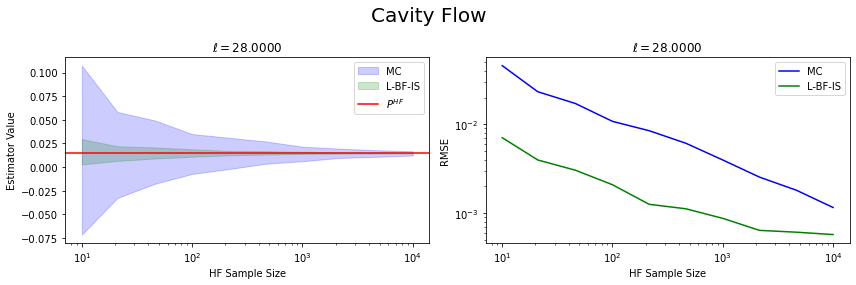

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Cavity Flow', fontsize=20)
scale = 1.96

axs[0].fill_between(MC_N_lst, MC_mean-scale*MC_std, MC_mean+scale*MC_std,color='b',alpha=0.2,label='MC')
axs[0].fill_between(MC_N_lst, IS_mean-scale*IS_std, IS_mean+scale*IS_std,color='g',alpha=0.2,label='L-BF-IS')
#axs[0].fill_between(MC_N_lst, GM_mean-scale*GM_std, GM_mean+scale*GM_std,color='r',alpha=0.2,label='GM')
axs[0].axhline(ExH,c='r',label=r'$P^{HF}$')
axs[0].set_xscale('log')
axs[0].set_xlabel('HF Sample Size')
axs[0].set_ylabel('Estimator Value')
axs[0].legend()
axs[0].set_title(f'$\ell={est.ell:.4f}$')

axs[1].plot(MC_N_lst, MC_rmse,color='b',alpha=1.0,label='MC')
axs[1].plot(MC_N_lst, IS_rmse,color='g',alpha=1.0,label='L-BF-IS')
#axs[1].plot(MC_N_lst, GM_rmse,color='r',alpha=1.0,label='GM')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel('HF Sample Size')
axs[1].set_ylabel('RMSE')
axs[1].legend()
axs[1].set_title(f'$\ell={est.ell:.4f}$')

fig.tight_layout()
# fig.savefig('../figures/cav.pdf', dpi=100)